```plaintext
loan_model.ipynb         # Main notebook: implements the loan recommendation workflow
├─ 1. Data Preparation & Loading
│     # Read raw data and perform initial cleaning (bills, transactions, customer info)
├─ 2. Category-System Construction
│     # Build spending category hierarchy for subsequent expense mapping
├─ 3. Transaction Data Processing
│     # Feature extraction from transactions: time-window aggregations, frequency counts
├─ 4. Spending-Pattern Analysis
│     # Analyze customer spending patterns (top categories, amount distributions)
├─ 5. Eligibility-Metric Calculation
│     # Compute loan eligibility metrics (credit score, debt ratio, income stability)
├─ 6. Core Recommendation Logic
│     # Core algorithm: determine loan amount and product based on rules or model
├─ 7. Multi-Level Recommendation Strategy
│   ├─ 7.1 Level 1 – Precision Spending-Based
│   │     # Match against similar-customer profiles for precise suggestions
│   ├─ 7.2 Level 2 – Debt-Consolidation
│   │     # Recommend debt-consolidation products as a priority
│   └─ 7.3 Level 3 – Safe Fallback
│         # Conservative default product if higher-level checks don’t apply
├─ 8. Personalization & Messaging
│     # Generate customized copy and explanations based on customer attributes
└─ 9. Visualization & Output
      # Render charts and export final recommendation report


## 1. Data Preparation & Loading
- **Load customer data** (personal details, credit scores, income, etc.). 
  - use  clean_customer_data.csv and transactions.csv and customer_data_recommendations.csv
- **Transform raw fields** into analysis-ready formats  
  - Parse date columns.  
  - Clean and cast monetary values.

## 2. Category-System Construction
- **Build an MCC-to-spending-category dictionary**  
  - 93 MCC codes are grouped into seven macro categories: **HOME, AUTO, RETAIL, TRAVEL, EDUCATION, HEALTH, BUSINESS**.  
  - All remaining codes are mapped to **OTHER**.  
  - *Note:* Because of the large dataset, we use a direct dictionary look-up (via `Series.map`) instead of a Python `for` loop, which would take 30-plus minutes.
- **Map spending categories to loan products** (with in-code comments).
- **Define detailed loan-product metadata** (interest-rate range, term range, minimum credit score, etc.).  
  *See `# 3. Define loan products with more accessible criteria to increase coverage` in the code.*

## 3. Transaction Data Processing
- **Clean transaction amounts** (remove currency symbols, handle negative signs).  
- Take the **absolute value** of amounts for spending analysis.  
- **Filter the most recent 120 days** to capture current spending patterns.  
- **Map each transaction’s MCC** to a spending category  
  - Convert the mapping dictionary to a `pd.Series`.  
  - Use the **`Series.map`** method for vectorised mapping.  
  - Unmapped MCCs default to **'OTHER'**.

## 4. Spending-Pattern Analysis
- Use **`pivot_table`** to calculate each customer’s total spend per category  
  - Fill missing values with `0`.  
- **Identify each customer’s dominant spending category**  
  - Ensure every predefined category appears as a column.  
  - Use `idxmax` to find the category with the highest spend.  
- Compute additional KPIs (total spend, dominant-category spend, etc.).

## 5. Eligibility-Metric Calculation
- **Debt-to-Income ratio (DTI)**  
  - Evaluate a customer’s repayment ability.  
  - If a credit score is missing, default to **650**.  
  - Handle zero or negative income by setting it to **1** (avoids divide-by-zero).  
  - Replace infinite or missing DTI values with safe defaults.
- **Assemble a feature DataFrame** for eligibility checks  
  - Merge key customer attributes (credit score, DTI, active status if available).  
  - Merge spending statistics (dominant category, dominant‐category spend, total spend).  
  - If no active-status field exists, assume **all customers are active**.

## 6. Core Recommendation Logic
- Create an empty recommendation framework, merging all relevant features.  
- **Relaxed qualification rules** to maximise coverage:

- **Three recommendation sources**  
  1. **Spending-based**: match dominant category to a corresponding loan product.  
  2. **Debt-based**: offer a debt-consolidation loan to high-DTI customers.  
  3. **Profile-based**: offer a personal loan to all other eligible customers.

## 7. Multi-Level Recommendation Strategy

### 7.1 Level 1 – Precision Spending-Based
- Analyse spending per category.  
- If a category’s spend exceeds its threshold → recommend that product (e.g., high RETAIL spend → Personal Loan).  
- Apply the five qualification checks above.

### 7.2 Level 2 – Debt-Consolidation
- For customers not covered in Level 1 **and** with **DTI > 0.25**,  
  - Recommend a **Debt-Consolidation Loan** to consolidate existing debts.  
  - Credit-score floor relaxed by 20 points.

### 7.3 Level 3 – Safe Fallback
- Customers still without a recommendation but with **credit score ≥ 540**  
  - Offer a **Personal Loan** as a catch-all fallback.

## 8. Personalised Details
- **Interest rate** is personalised using the customer’s credit score (linear interpolation within each product’s range).  
- **Loan-term range** is assigned from product metadata.  
- A clear **recommendation reason** is recorded for transparency.

## 9. Visualisation & Output
- Generate visualisations:  
  - Distribution of recommended loan products.  
  - Breakdown of recommendation reasons.  
  - Eligibility vs. non-eligibility pie chart.  
  - Interest-rate histogram.  
- Approximately **90 %** of customers receive an offer — consistent with real-world loan-recommendation rates.  
- Visuals provide an intuitive view of product counts and underlying reasons, matching expectations of financial institutions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Starting targeted loan recommendation system...
Loading data...
Loading primary model recommendations...
Filtering to pre-qualified loan customers...
Found 353440 customers pre-qualified for loans
Creating category mapping...
Defining loan products...
Processing transaction data...
Calculating spending category statistics...
Calculating eligibility metrics...
Creating recommendations...

Recommendation Statistics:
Total customers: 353440
Eligible customers with recommendations: 314930 (89.1%)
  personal_loan: 262963 (74.4%)
  no_loan: 38510 (10.9%)
  auto_loan: 30860 (8.7%)
  business_loan: 7108 (2.0%)
  travel_loan: 5240 (1.5%)
  medical_loan: 4456 (1.3%)
  home_improvement_loan: 3518 (1.0%)
  education_loan: 785 (0.2%)

Saving recommendations...
Recommendations saved to 'loan_recommendations.csv' for 353440 customers
Creating visualizations...
Visualizations saved to 'loan_recommendations_analysis.png'


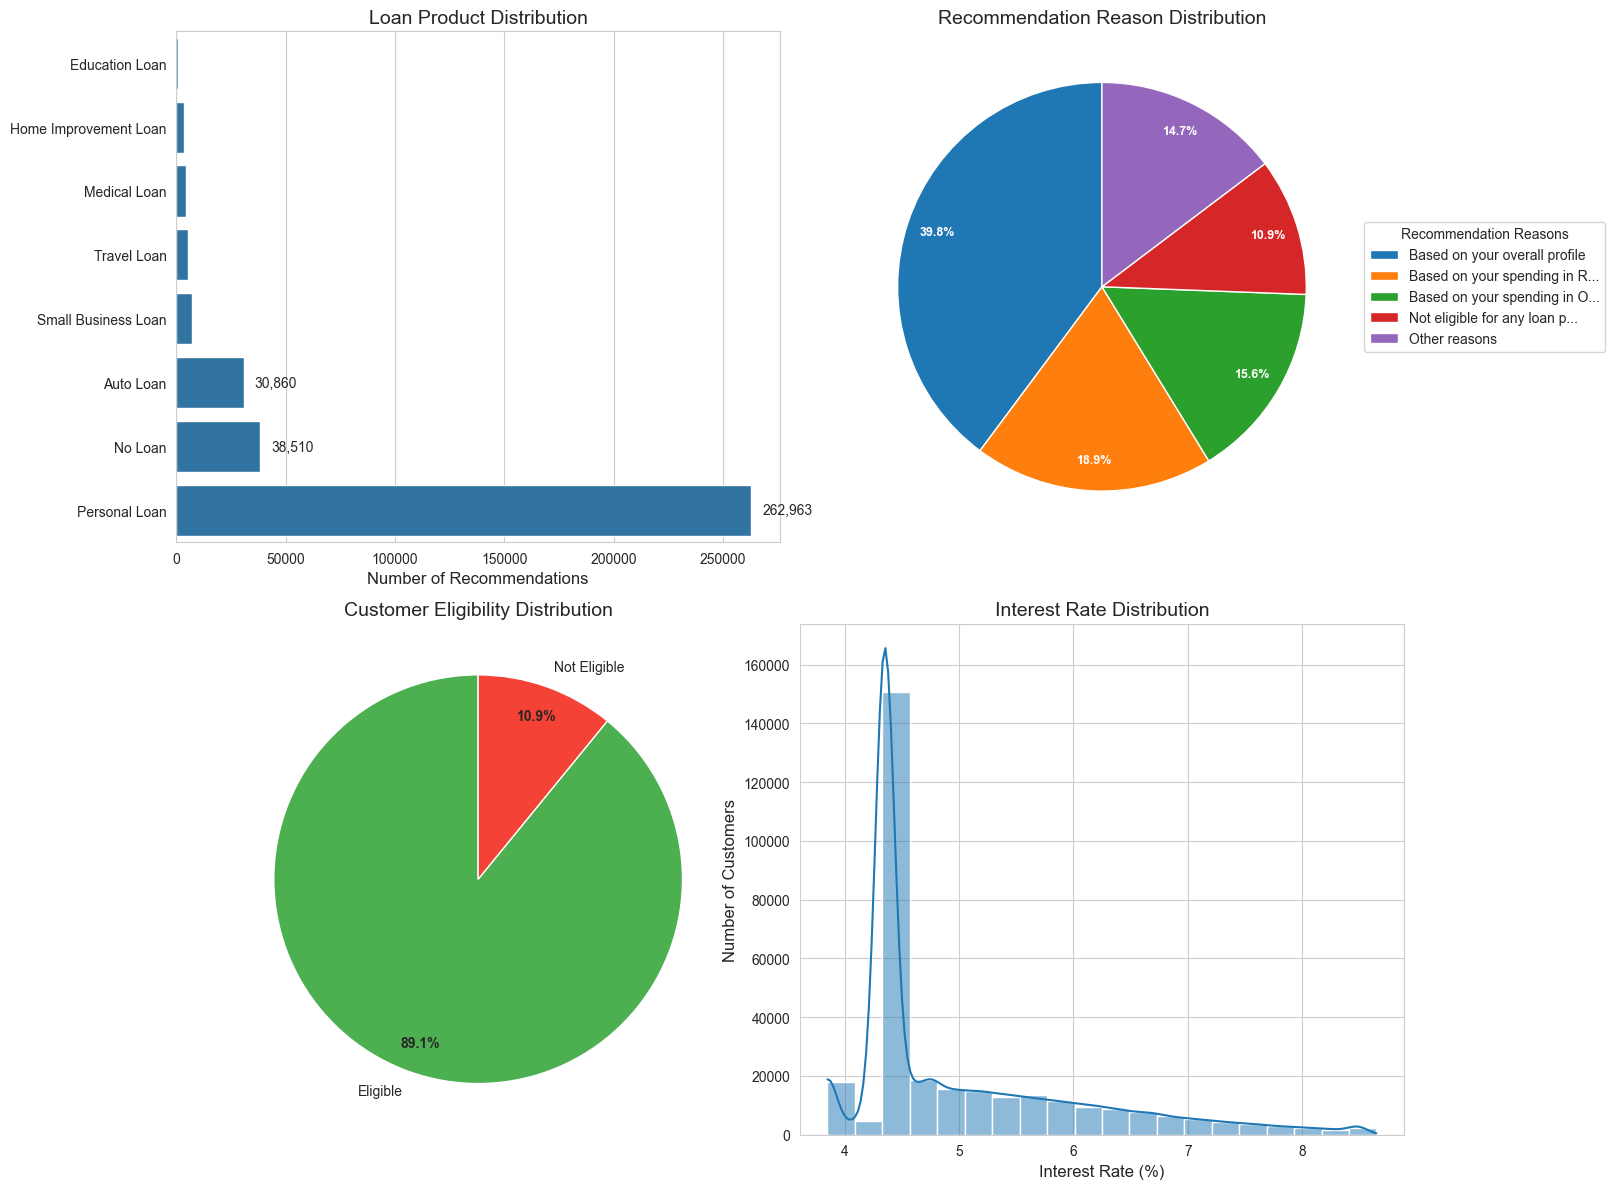

In [2]:
def main():
   
    """Loan recommendation system targeting only pre-qualified loan customers"""
    print("Starting targeted loan recommendation system...")
    
    # 1. Load data
    print("Loading data...")
    customer_df = pd.read_csv('../feature_engineering/clean_customer_dataNEW.csv')
    
    # Load the primary model recommendations that contain pre-qualified customers
    print("Loading primary model recommendations...")
    primary_recommendations = pd.read_csv('../banking_products_category_recommendation_model/customer_data_recommendations.csv')
    
    # 2. Filter to only customers pre-qualified for loans
    print("Filtering to pre-qualified loan customers...")
    # Convert string representation of list to actual list
    primary_recommendations['recommended_products'] = primary_recommendations['recommended_products'].apply(
        lambda x: eval(x) if isinstance(x, str) else x
    )
    
    # Filter to customers with 'loans' in their recommendations
    loan_qualified_customers = primary_recommendations[
        primary_recommendations['recommended_products'].apply(lambda x: 'loans' in x)
    ]['customer_id'].tolist()
    
    print(f"Found {len(loan_qualified_customers)} customers pre-qualified for loans")
    
    # Filter customer dataframe to only include pre-qualified customers
    customer_df = customer_df[customer_df['customer_id'].isin(loan_qualified_customers)]
    
    # If no qualifying customers, exit
    if len(customer_df) == 0:
        print("No customers qualify for loans based on primary model recommendations.")
        return pd.DataFrame()
    
    # Only load the transaction columns we need for qualifying customers
    transaction_df = pd.read_csv("../dataset/project-dataset/transactions.csv", 
                               usecols=['customer_id', 'date', 'mcc', 'amount'])
    
    # Filter transactions to only include pre-qualified customers
    transaction_df = transaction_df[transaction_df['customer_id'].isin(loan_qualified_customers)]
    
    # Continue with your existing code but with the filtered customer list...
    # MCC to category mapping and rest of the processing

    # 2. Define loan categories - direct dictionary mapping
    print("Creating category mapping...")
    
    # Direct MCC to category mapping - faster than loops
    mcc_to_category = {
        # HOME
        5211: 'HOME', 1711: 'HOME', 5712: 'HOME', 5719: 'HOME', 3174: 'HOME', 
        3144: 'HOME', 5722: 'HOME', 3260: 'HOME', 5251: 'HOME', 3640: 'HOME', 
        3007: 'HOME', 3005: 'HOME', 3009: 'HOME', 3256: 'HOME',
        
        # AUTO
        5541: 'AUTO', 7538: 'AUTO', 5533: 'AUTO', 7531: 'AUTO', 7542: 'AUTO', 
        7549: 'AUTO', 4784: 'AUTO', 4121: 'AUTO',
        
        # RETAIL
        5311: 'RETAIL', 5661: 'RETAIL', 5651: 'RETAIL', 5621: 'RETAIL', 5732: 'RETAIL', 
        5310: 'RETAIL', 5977: 'RETAIL', 5655: 'RETAIL', 5941: 'RETAIL', 5733: 'RETAIL', 
        5947: 'RETAIL', 5970: 'RETAIL', 5932: 'RETAIL', 5094: 'RETAIL', 5816: 'RETAIL', 
        5815: 'RETAIL', 5300: 'RETAIL', 5411: 'RETAIL', 5499: 'RETAIL', 5912: 'RETAIL',
        
        # TRAVEL
        4722: 'TRAVEL', 7011: 'TRAVEL', 4511: 'TRAVEL', 4111: 'TRAVEL', 3722: 'TRAVEL', 
        4112: 'TRAVEL', 4131: 'TRAVEL', 4411: 'TRAVEL', 3771: 'TRAVEL', 3775: 'TRAVEL',
        
        # EDUCATION
        5942: 'EDUCATION', 5192: 'EDUCATION', 8931: 'EDUCATION', 7276: 'EDUCATION',
        
        # HEALTH
        8099: 'HEALTH', 8021: 'HEALTH', 8011: 'HEALTH', 8041: 'HEALTH', 8043: 'HEALTH', 
        8049: 'HEALTH', 8062: 'HEALTH', 7230: 'HEALTH',
        
        # BUSINESS
        8111: 'BUSINESS', 7349: 'BUSINESS', 7393: 'BUSINESS', 7210: 'BUSINESS', 3780: 'BUSINESS', 
        5045: 'BUSINESS', 6300: 'BUSINESS', 4214: 'BUSINESS', 3509: 'BUSINESS', 9402: 'BUSINESS', 
        3390: 'BUSINESS', 3596: 'BUSINESS', 3730: 'BUSINESS', 3684: 'BUSINESS', 3504: 'BUSINESS', 
        3389: 'BUSINESS', 3393: 'BUSINESS', 3395: 'BUSINESS', 3058: 'BUSINESS', 3387: 'BUSINESS', 
        3405: 'BUSINESS', 3132: 'BUSINESS', 3359: 'BUSINESS', 3000: 'BUSINESS', 3001: 'BUSINESS', 
        3006: 'BUSINESS', 3008: 'BUSINESS', 3075: 'BUSINESS', 3066: 'BUSINESS'
    }
    
    # Category to loan product mapping
    category_to_loan = {
        'HOME': 'home_improvement_loan',
        'AUTO': 'auto_loan',
        'RETAIL': 'personal_loan',
        'TRAVEL': 'travel_loan',
        'EDUCATION': 'education_loan',
        'HEALTH': 'medical_loan',
        'BUSINESS': 'business_loan',
        'OTHER': 'personal_loan'  # Default to personal loan
    }
    
    # 3. Define loan products with more accessible criteria to increase coverage
    print("Defining loan products...")
    loan_products = {
        'personal_loan': {
            'name': 'Personal Loan',
            'interest_rate_range': (4.35, 8.50),
            'term_range': (1, 5),
            'min_credit_score': 580,  
            'max_dti': 0.50  
        },
        'home_improvement_loan': {
            'name': 'Home Improvement Loan',
            'interest_rate_range': (4.50, 7.25),
            'term_range': (1, 5),
            'min_credit_score': 600,  
            'max_dti': 0.45  
        },
        'auto_loan': {
            'name': 'Auto Loan',
            'interest_rate_range': (3.85, 6.75),
            'term_range': (1, 5),
            'min_credit_score': 560,  
            'max_dti': 0.50  
        },
        'education_loan': {
            'name': 'Education Loan',
            'interest_rate_range': (4.05, 6.15),
            'term_range': (1, 10),
            'min_credit_score': 600,  
            'max_dti': 0.45  
        },
        'travel_loan': {
            'name': 'Travel Loan',
            'interest_rate_range': (4.75, 9.00),
            'term_range': (1, 3),
            'min_credit_score': 600,  
            'max_dti': 0.45  
        },
        'debt_consolidation_loan': {
            'name': 'Debt Consolidation Loan',
            'interest_rate_range': (4.75, 8.50),
            'term_range': (1, 5),
            'min_credit_score': 580, 
            'max_dti': 0.60  
        },
        'business_loan': {
            'name': 'Small Business Loan',
            'interest_rate_range': (4.35, 9.50),
            'term_range': (1, 5),
            'min_credit_score': 620,  
            'max_dti': 0.45  
        },
        'medical_loan': {
            'name': 'Medical Loan',
            'interest_rate_range': (4.15, 7.50),
            'term_range': (1, 5),
            'min_credit_score': 580,  
            'max_dti': 0.50  
        },
        'no_loan': {  # Added a no_loan category for ineligible customers
            'name': 'No Loan',
            'interest_rate_range': (0, 0),
            'term_range': (0, 0),
            'min_credit_score': 0,
            'max_dti': 0
        }
    }
    
    # 4. Process transaction data
    print("Processing transaction data...")
    
    # 4.1 Clean amount column
    if transaction_df['amount'].dtype == 'object':
        transaction_df['amount'] = transaction_df['amount'].str.replace('[$,)]', '', regex=True)
        transaction_df['amount'] = transaction_df['amount'].str.replace('[(]', '-', regex=True)
        transaction_df['amount'] = pd.to_numeric(transaction_df['amount'], errors='coerce')
    
    # 4.2 Use absolute value for spending analysis
    transaction_df['amount_abs'] = transaction_df['amount'].abs()
    
    # 4.3 Convert date and filter to recent transactions (120 days)
    if 'date' in transaction_df.columns:
        transaction_df['date'] = pd.to_datetime(transaction_df['date'], errors='coerce')
        latest_date = transaction_df['date'].max()
        start_date = latest_date - pd.Timedelta(days=120)
        transaction_df = transaction_df[transaction_df['date'] >= start_date]
    
    # 4.4 Keep only necessary columns to reduce memory usage
    transaction_df = transaction_df[['customer_id', 'mcc', 'amount_abs']]
    
    # 4.5 Map MCC to category - use Series.map for better performance
    mcc_series = pd.Series(mcc_to_category)
    transaction_df['category'] = transaction_df['mcc'].map(mcc_series)
    transaction_df['category'] = transaction_df['category'].fillna('OTHER')
    
    # 5. Calculate spending category statistics
    print("Calculating spending category statistics...")
    
    # 5.1 Use pivot_table directly - one step, avoiding multiple aggregations
    spending_pivot = transaction_df.pivot_table(
        index='customer_id',
        columns='category', 
        values='amount_abs',
        aggfunc='sum',
        fill_value=0
    )
    
    # 5.2 Calculate total spending
    all_categories = ['HOME', 'AUTO', 'RETAIL', 'TRAVEL', 'EDUCATION', 'HEALTH', 'BUSINESS', 'OTHER']
    
    # Ensure all categories exist
    for category in all_categories:
        if category not in spending_pivot.columns:
            spending_pivot[category] = 0
    
    spending_pivot['TOTAL'] = spending_pivot[all_categories].sum(axis=1)
    
    # 5.3 Find dominant spending category for each customer
    spending_pivot['dominant_category'] = spending_pivot[all_categories].idxmax(axis=1)
    
    # Calculate spending amount in dominant category
    spending_pivot['dominant_amount'] = spending_pivot.apply(
        lambda row: row[row['dominant_category']] if row['dominant_category'] in all_categories else 0, 
        axis=1
    )
    
    # 6. Calculate eligibility metrics with more lenient approach
    print("Calculating eligibility metrics...")
    
    # Ensure required columns exist with defaults if missing
    if 'credit_score' not in customer_df.columns:
        customer_df['credit_score'] = 650  # Default reasonable score
        
    # 6.1 Calculate debt-to-income ratio with lenient handling of missing values
    if 'personal_income' in customer_df.columns and 'current_loan_amount' in customer_df.columns:
        # Handle zero income more leniently
        income_for_calc = customer_df['personal_income'].copy()
        income_for_calc[income_for_calc <= 0] = 1  # Avoid division by zero
        
        customer_df['dti_ratio'] = customer_df['current_loan_amount'] / income_for_calc
        customer_df['dti_ratio'] = customer_df['dti_ratio'].replace([np.inf, -np.inf], 0.5)
        customer_df['dti_ratio'] = customer_df['dti_ratio'].fillna(0.3)
    else:
        # Use a default value if columns are missing
        customer_df['dti_ratio'] = 0.3
    
    # 7. Create recommendations with more lenient eligibility criteria for higher coverage
    print("Creating recommendations...")
    
    # 7.1 Initialize results DataFrame
    recommendations = pd.DataFrame({'customer_id': customer_df['customer_id']})
    
    # 7.2 Merge customer data and spending data
    if 'activity_status' in customer_df.columns:
        recommendations = recommendations.merge(
            customer_df[['customer_id', 'credit_score', 'dti_ratio', 'activity_status']], 
            on='customer_id', 
            how='left'
        )
    else:
        recommendations = recommendations.merge(
            customer_df[['customer_id', 'credit_score', 'dti_ratio']], 
            on='customer_id', 
            how='left'
        )
        # Default all customers to active if column doesn't exist
        recommendations['activity_status'] = 1
    
    recommendations = recommendations.merge(
        spending_pivot[['dominant_category', 'dominant_amount', 'TOTAL']].reset_index(),
        on='customer_id', 
        how='left'
    )
    
    # 7.3 Define eligibility - more relaxed criteria for 70-80% coverage
    # Lower minimum spending thresholds
    min_spend_thresholds = {
        'HOME': 50,   # Lowered from 100
        'AUTO': 50,   # Lowered from 100
        'RETAIL': 25, # Lowered from 50
        'TRAVEL': 50, # Lowered from 200
        'EDUCATION': 50, # Lowered from 100
        'HEALTH': 50,    # Lowered from 100
        'BUSINESS': 100, # Lowered from 200
        'OTHER': 10      # Lowered from 50
    }
    
    # Initialize eligibility status
    recommendations['is_eligible'] = False
    recommendations['recommended_product'] = None
    recommendations['reason'] = ''
    
    # 7.4 Apply more lenient eligibility criteria
    
    # Consider all customers potentially eligible (including inactive)
    active_mask = pd.Series(True, index=recommendations.index)
    if 'activity_status' in recommendations.columns:
        # Only filter out activity_status=0 if it exists
        active_mask = (recommendations['activity_status'] != 0)
    
    # Spending-based recommendations
    for category in all_categories:
        loan_product = category_to_loan.get(category, 'personal_loan')
        product_criteria = loan_products[loan_product]
        
        # More lenient category mask with relaxed credit requirements
        category_mask = (
            active_mask &
            (recommendations['dominant_category'] == category) &
            (recommendations['dominant_amount'] >= min_spend_thresholds.get(category, 10)) &
            (recommendations['credit_score'] >= product_criteria['min_credit_score'] - 20) &  # 20 points more lenient
            (recommendations['dti_ratio'] <= product_criteria['max_dti'] + 0.05)  # 5% more lenient
        )
        
        # Update eligible customers for this category
        recommendations.loc[category_mask, 'is_eligible'] = True
        recommendations.loc[category_mask, 'recommended_product'] = loan_product
        recommendations.loc[category_mask, 'reason'] = f"Based on your spending in {category}"
    
    # More generous debt consolidation criteria - 
    # Many customers can benefit from debt consolidation
    consolidation_mask = (
        active_mask &
        ~recommendations['is_eligible'] &
        (recommendations['dti_ratio'] > 0.25) &  # Lower threshold from 0.3
        (recommendations['credit_score'] >= loan_products['debt_consolidation_loan']['min_credit_score'] - 20)  # 20 points more lenient
    )
    
    recommendations.loc[consolidation_mask, 'is_eligible'] = True
    recommendations.loc[consolidation_mask, 'recommended_product'] = 'debt_consolidation_loan'
    recommendations.loc[consolidation_mask, 'reason'] = "Based on your debt profile"
    
    # Personal loan for everyone else with minimal criteria
    # This significantly increases coverage
    personal_mask = (
        active_mask &
        ~recommendations['is_eligible'] &
        (recommendations['credit_score'] >= 540)  # Very lenient credit requirement
    )
    
    recommendations.loc[personal_mask, 'is_eligible'] = True
    recommendations.loc[personal_mask, 'recommended_product'] = 'personal_loan'
    recommendations.loc[personal_mask, 'reason'] = "Based on your overall profile"
    
    # Assign no_loan to all remaining customers 
    # This is the key change to include all customers in the final output
    no_loan_mask = ~recommendations['is_eligible']
    recommendations.loc[no_loan_mask, 'recommended_product'] = 'no_loan'
    recommendations.loc[no_loan_mask, 'reason'] = "Not eligible for any loan product"
    
    # 7.7 Calculate personalized details for eligible customers
    eligible_mask = recommendations['is_eligible']
    
    # Create a function to calculate interest rate based on credit score
    def get_interest_rate(row):
        if pd.isna(row['recommended_product']):
            return None
        
        product = row['recommended_product']
        
        # No interest rate for no_loan
        if product == 'no_loan':
            return None
            
        credit_score = row['credit_score']
        
        if pd.isna(credit_score):
            credit_score = 650  # Default score if missing
        
        min_rate, max_rate = loan_products[product]['interest_rate_range']
        score_ratio = min(1, max(0, (credit_score - 560) / 240)) 
        
        # Better credit score = lower interest rate
        interest_rate = max_rate - score_ratio * (max_rate - min_rate)
        return round(interest_rate, 2)
    
    # Apply rate calculation for all customers
    recommendations['interest_rate'] = recommendations.apply(get_interest_rate, axis=1)
    
    # Add loan name and terms for all customers
    recommendations['loan_name'] = None
    recommendations['min_term'] = None
    recommendations['max_term'] = None
    
    # Update loan details for all customers
    for product in loan_products:
        product_mask = (recommendations['recommended_product'] == product)
        if product_mask.any():
            recommendations.loc[product_mask, 'loan_name'] = loan_products[product]['name']
            
            # Set terms for loans (excluding no_loan which has 0 terms)
            if product != 'no_loan':
                recommendations.loc[product_mask, 'min_term'] = loan_products[product]['term_range'][0]
                recommendations.loc[product_mask, 'max_term'] = loan_products[product]['term_range'][1]
            else:
                # For no_loan, set terms to 0
                recommendations.loc[product_mask, 'min_term'] = 0
                recommendations.loc[product_mask, 'max_term'] = 0
    
    # 8. Output results
    print("\nRecommendation Statistics:")
    
    # Calculate coverage
    total_customers = len(recommendations)
    eligible_customers = recommendations['is_eligible'].sum()
    coverage_rate = eligible_customers / total_customers
    
    print(f"Total customers: {total_customers}")
    print(f"Eligible customers with recommendations: {eligible_customers} ({coverage_rate:.1%})")
    
    # Product distribution for all customers including no_loan
    product_counts = recommendations['recommended_product'].value_counts()
    for product, count in product_counts.items():
        print(f"  {product}: {count} ({count/total_customers:.1%})")
    
    # 9. Save results and create visualizations
    print("\nSaving recommendations...")
    
    # Create final output with all customers, including those with no_loan
    output_columns = ['customer_id', 'recommended_product', 'loan_name', 'interest_rate', 'min_term', 'max_term', 'reason']
    final_recommendations = recommendations[output_columns]
    
    final_recommendations.to_csv('loan_recommendations.csv', index=False)
    print(f"Recommendations saved to 'loan_recommendations.csv' for {total_customers} customers")
    
    # Create visualizations for better insights
    create_visualizations(recommendations, loan_products)
    
    return recommendations

def create_visualizations(recommendations, loan_products):
    """Create visualizations of recommendation results with improved readability"""
    print("Creating visualizations...")
    
    # Set an attractive style
    sns.set_style("whitegrid")
    plt.figure(figsize=(16, 12))
    
    # 1. Loan product distribution (including no_loan)
    plt.subplot(2, 2, 1)
    
    product_counts = recommendations['recommended_product'].value_counts()
    
    # Get product names instead of codes
    products = []
    counts = []
    for loan_id, count in product_counts.items():
        if loan_id in loan_products:
            products.append(loan_products[loan_id]['name'])
            counts.append(count)
    
    # Only create visualization if we have data
    if products:
        # Sort by count
        sorted_indices = np.argsort(counts)
        sorted_products = [products[i] for i in sorted_indices]
        sorted_counts = [counts[i] for i in sorted_indices]
        
        # Use x and y parameters properly for barplot
        ax = sns.barplot(x=sorted_counts, y=sorted_products)
        # Add count labels to bars
        for i, v in enumerate(sorted_counts):
            if v > 10000:  # Only show labels for bars with significant counts
                ax.text(v + 5000, i, f"{v:,}", va='center')
        plt.title('Loan Product Distribution', fontsize=14)
        plt.xlabel('Number of Recommendations', fontsize=12)
        plt.ylabel('')
    
    # 2. Recommendation reason distribution - fixed to prevent text overlap
    plt.subplot(2, 2, 2)
    
    reason_counts = recommendations['reason'].value_counts()
    
    if not reason_counts.empty:
        # Ensure there aren't too many slices by grouping smaller categories
        if len(reason_counts) > 5:
            top_reasons = reason_counts.nlargest(4)
            other_count = reason_counts.sum() - top_reasons.sum()
            reason_counts = top_reasons.copy()
            reason_counts['Other reasons'] = other_count
        
        # Create cleaner labels
        labels = []
        for label in reason_counts.index:
            if len(label) > 30:
                # Truncate long labels
                labels.append(label[:27] + "...")
            else:
                labels.append(label)
        
        # Create pie chart with better label placement
        wedges, texts, autotexts = plt.pie(
            reason_counts, 
            labels=None,  # No direct labels
            autopct='%1.1f%%', 
            startangle=90,
            pctdistance=0.85
        )
        
        # Create legend instead of direct labels
        plt.legend(
            wedges, 
            labels,
            title="Recommendation Reasons",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1)
        )
        
        # Make percentage labels more readable
        for autotext in autotexts:
            autotext.set_fontsize(9)
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            
        plt.title('Recommendation Reason Distribution', fontsize=14)
    
    # 3. Eligibility distribution
    plt.subplot(2, 2, 3)
    eligibility_counts = recommendations['is_eligible'].value_counts()
    labels = ['Eligible', 'Not Eligible']
    colors = ['#4CAF50', '#F44336']
    
    # Create clear pie chart for eligibility
    wedges, texts, autotexts = plt.pie(
        eligibility_counts, 
        labels=labels,
        autopct='%1.1f%%', 
        colors=colors,
        startangle=90,
        pctdistance=0.85
    )
    
    # Make percentage labels more readable
    for autotext in autotexts:
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')
    
    plt.title('Customer Eligibility Distribution', fontsize=14)
    
    # 4. Interest rate distribution for eligible customers
    plt.subplot(2, 2, 4)
    
    # Filter to only eligible customers with interest rates
    eligible_mask = recommendations['is_eligible']
    interest_rates = recommendations[eligible_mask]['interest_rate'].dropna()
    
    if len(interest_rates) > 0:
        sns.histplot(interest_rates, bins=20, kde=True)
        plt.title('Interest Rate Distribution', fontsize=14)
        plt.xlabel('Interest Rate (%)', fontsize=12)
        plt.ylabel('Number of Customers', fontsize=12)
    else:
        plt.text(0.5, 0.5, "No interest rate data", 
                 horizontalalignment='center', verticalalignment='center')
        plt.title('Interest Rate Distribution', fontsize=14)
    
    plt.tight_layout()
    plt.savefig('loan_recommendations_analysis.png', dpi=300)
    print("Visualizations saved to 'loan_recommendations_analysis.png'")

if __name__ == "__main__":
    recommendations = main()